In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date
from datetime import datetime
import scipy.stats

# Lectura de datos de COVID-19

In [2]:
# Lectura de datos
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFileDUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv' #Muertes en Estados unidos
DataFileCUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv' #Casos confirmados en estados unidos

cvaDUS = pd.read_csv('{}{}'.format(DataSource,DataFileDUS))
cvaCUS = pd.read_csv('{}{}'.format(DataSource,DataFileCUS))

In [3]:
# Obtencion de fecha del día de ayer para iniciar análisis con datos del último día
d = date.today()
AYER = str(d.month)+'/'+str(d.day-1)+'/'+str(d.year)[-2:]
AYER

'5/5/20'

In [4]:
# Datos provistos por CSSE de la universidad de Johns Hopkins
print('Casos hasta ayer en USA:',cvaCUS[AYER].sum(),'\nMuertes hasta ayer en USA:',cvaDUS[AYER].sum())

Casos hasta ayer en USA: 1204351 
Muertes hasta ayer en USA: 71064


# Limpieza de datos de COVID-19

In [5]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCases = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVCases.columns = ['CASOS']

COVDeaths = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVDeaths.columns = ['MUERTES']

# Eliminar datos que categorizados como 'Unassigned'
COV = pd.merge(COVCases, COVDeaths, how = 'inner', left_index=True, right_index=True)
print('Casos sin asignar que se eliminaron:\n'+str(COV.xs('Unassigned', level='Admin2').sum()))
COV = COV.drop('Unassigned', level='Admin2')
COV.index.names = ['Estado', 'Condado']
COV

Casos sin asignar que se eliminaron:
CASOS      4542
MUERTES     594
dtype: int64


CASOS  MUERTES
Estado        Condado                  
Alabama       Autauga       53        3
              Baldwin      189        5
              Barbour       47        1
              Bibb          43        0
              Blount        40        0
...                        ...      ...
Virginia      Out of VA      0        0
Washington    Out of WA      0        0
West Virginia Out of WV      0        0
Wisconsin     Out of WI      0        0
Wyoming       Out of WY      0        0

[3193 rows x 2 columns]

# Cálculo de Mortalidad
$$ Mortalidad = \frac{Muertes}{Casos}  $$

In [6]:
COV['MORTALIDAD'] = COV['MUERTES']/COV['CASOS']
COV.head()
COV = COV.reset_index()
COV.head()

,Estado,Condado,CASOS,MUERTES,MORTALIDAD
0,Alabama,Autauga,53,3,0.056604
1,Alabama,Baldwin,189,5,0.026455
2,Alabama,Barbour,47,1,0.021277
3,Alabama,Bibb,43,0,0.000000
4,Alabama,Blount,40,0,0.000000


# Lectura de datos de PM2.5
Fuente: EPA
#### ESTE ES EL PASO  MAS LARGO

In [7]:
Directorio = 'DatosPM2.5/'
almacenarVar = False

# Lectura de primer archivo csv 
# PM25 = (pd.read_csv(Directorio+'ad_viz_plotval_data.csv')
#                                    .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']]
#                                    .apply(lambda df : pd.Series({'Mes': int(df['Date'][0:2]),'Date':df.Date,'Promedio mensual':df['Daily Mean PM2.5 Concentration']}),axis = 1)
#                                    .groupby(['STATE','COUNTY','Mes'])
#                                    .mean())
PM25 = pd.DataFrame()
for i in range(51):
    #Lectura para datos promedios mensuales para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']]
                                   .apply(lambda df : pd.Series({'Mes': int(df['Date'][0:2]),'Date':df.Date,'Promedio mensual':df['Daily Mean PM2.5 Concentration']}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes'])
                                   .mean())
    
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    PM25 = PM25.append(PMC)
    
PM25 = PM25.reset_index()
PM25

,STATE,COUNTY,Mes,Promedio mensual
0,Alabama,Jefferson,1,7.636364
1,Alabama,Jefferson,2,7.312057
2,Alabama,Jefferson,3,9.279221
3,Alabama,Jefferson,4,9.146000
4,Alabama,Jefferson,5,10.206667
...,...,...,...,...
2919,Wyoming,Teton,1,0.196774
2920,Wyoming,Teton,2,0.544828
2921,Wyoming,Teton,3,0.792308
2922,Wyoming,Teton,4,0.496552


# Unión de datos de COVID y PM2.5

In [57]:
COVyPM25 = pd.merge(COV, PM25, how='inner', left_on=['Estado','Condado'], right_on=['STATE', 'COUNTY']).set_index(['Estado','Condado']).drop(['STATE','COUNTY'], axis=1)
COVyPM25[np.isnan(COVyPM25['MORTALIDAD'])]=0 #Reemplazo valores en donde no hay ni casos ni muertes como mortalidad = 0
COVyPM25.head()
print('Cantidad de observaciones =',len(COVyPM25))
print('Cantidad de condados con observaciones =', len(COVyPM25.groupby('Condado').mean()))

CASOS  MUERTES  MORTALIDAD  Mes  Promedio mensual
Estado  Condado                                                     
Alabama Jefferson   1020       49    0.048039    1          7.636364
        Jefferson   1020       49    0.048039    2          7.312057
        Jefferson   1020       49    0.048039    3          9.279221
        Jefferson   1020       49    0.048039    4          9.146000
        Jefferson   1020       49    0.048039    5         10.206667

# Obtención de matrices de correlación

In [ ]:
# fig = plt.figure(figsize=(29,16))

fig3 = plt.figure(constrained_layout=True, figsize=(15,15))
gs = fig3.add_gridspec(3, 3)

f3_ax1 = fig3.add_subplot(gs[0, 1:])
f3_ax1.text(0.13,0.5,'Matrices de Correlación', fontsize=48)
f3_ax1.set_yticks([])
f3_ax1.set_xticks([])
f3_ax1.axis('off')

for i in range(3):
#     plt.subplot(2,3,i+1)
    f3_ax1 = fig3.add_subplot(gs[i, 0])
    # Obtencion R Pearson y P-Value
    R, PVal = scipy.stats.pearsonr(COVyPM25[COVyPM25.Mes == i+1]['MORTALIDAD'],COVyPM25[COVyPM25.Mes == i+1]['Promedio mensual']) 
    f3_ax1.set_title('Concentraciones en mes 0'+str(i+1)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[COVyPM25.Mes == i+1])))
    # Matriz de correlacion mes de Enero
    (sns.heatmap(
        COVyPM25[COVyPM25.Mes == i+1]
        .drop('Mes',axis=1)
        .corr(),
        cmap = 'seismic',
        center=0))
#     plt.title('Concentraciones en mes 0'+str(i+1)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[COVyPM25.Mes == i+1])))
    
# plt.subplot(236)
f3_ax1 = fig3.add_subplot(gs[1:, 1:3])
R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes', axis=1)['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes', axis=1)['Promedio mensual']) 
(sns.heatmap(
    COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)]
    .groupby(['Estado','Condado'])
    .mean()
    .drop('Mes',axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))


f3_ax1.set_title('Concentraciones en meses 01-02-03 con R ='+ str(round(R,4)) + ' $P_{Value}$= '+str(round(PVal,4)) +'\n#Obs = '+ str(len(COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean())))

fig3.savefig('MatrizDeCorrelacionDeCadaMes.png', dpi=100)

C:\Users\mdomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\mdomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


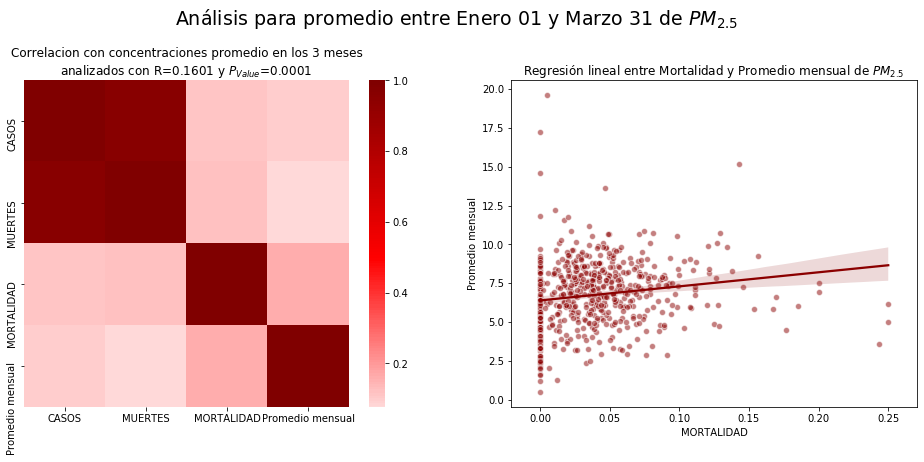

In [76]:
# Matriz de correlacion para promedio de los 5 meses
fig = plt.figure(figsize=(16,6))
R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes',axis=1)['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes',axis=1)['Promedio mensual']) 
plt.subplot(121)
plt.title('Correlacion con concentraciones promedio en los 3 meses\nanalizados con R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))
(sns.heatmap(COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes',axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))
plt.subplot(122)
sns.regplot(COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes',axis=1)['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == 1)|(COVyPM25.Mes == 2)|(COVyPM25.Mes == 3)].groupby(['Estado','Condado']).mean().drop('Mes',axis=1)['Promedio mensual'],color='darkred',scatter_kws=dict(alpha=0.5,edgecolor='white'))
plt.title('Regresión lineal entre Mortalidad y Promedio mensual de $PM_{2.5}$')
plt.suptitle('Análisis para promedio entre Enero 01 y Marzo 31 de $PM_{2.5}$',y=1.05, fontsize=19)

fig.savefig('Matriz de correlación y regresion lineal.png',dpi=200)